In [3]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add


In [5]:
BASE_DIR= 'flickr8k'
WORKING_DIR=''

In [3]:
model=VGG16()
#restructuring the loaded VGG16 model
model=Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [4]:
# extract features from image
features={}
directory=os.path.join(BASE_DIR,'Images')

for img_name in tqdm(os.listdir(directory)):
  #load image from file
  img_path=directory+'/'+img_name
  image=load_img(img_path,target_size=(224,224))
  #convert image pixels to numpy array
  image=img_to_array(image)
  #reshaping data for model
  image=image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
  #preprocess image for VGG16 model
  image=preprocess_input(image)
  #extract features
  feature=model.predict(image,verbose=0)
  #get image ID
  image_id=img_name.split('.')[0]
  #store features
  features[image_id]=feature

  0%|          | 0/8091 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


In [5]:
#storing the extracted features in pickle
pickle.dump(features,open(os.path.join(WORKING_DIR, 'features.pk1'), 'wb'))

In [7]:
#load features form pickle
with open(os.path.join(WORKING_DIR, 'features.pk1'), 'rb') as f:
    features =pickle.load(f)

In [8]:
#loading captions 
with open(os.path.join(BASE_DIR, 'captions.txt'), 'rb') as f:
    next(f)
    captions_doc=f.read().decode('utf-8')

In [11]:
captions_doc

'1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .\n1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .\n1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting\n1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .\n1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .\n1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .\n1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .\n1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .\n1002674143_1b742ab4b8.j

In [13]:
#create mapping of image to captions
mapping={}
#process lines
for line in tqdm(captions_doc.split('\n')):
    #splitting the line by comma
    tokens=line.split(',')
    if len(line)<2:
        continue
    image_id, caption=tokens[0], tokens[1:]
    #remove extension from image ID
    image_id=image_id.split('.')[0]
    #convert caption list to string
    caption=" ".join(caption)
    #create list if required
    if image_id not in mapping:
        mapping[image_id]=[]
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [15]:
len(mapping)

8091

In [17]:
def clean(mapping):
    for key,captions in mapping.items():
        for i in range(len(captions)):
            caption=captions[i]
            #preprocessing steps
            caption=caption.lower()
            #removing special characters and digits and anything not an alphabet
            caption=caption.replace('[^A-Za+z]','')
            #removing additional spaces
            caption=caption.replace('\s+',' ')
            #add start and end tags to caption
            caption='startseq '+ " ".join([word for word in caption.split() if len(word)>1])+ ' endseq'
            captions[i]=caption

<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
/var/folders/6f/sk6f_fn57_1b_pqwy57yk_140000gn/T/ipykernel_70943/2057782578.py:10: SyntaxWarning: invalid escape sequence '\s'
  caption=caption.replace('\s+',' ')


In [19]:
#before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [21]:
#preprocessing text
clean(mapping)

In [23]:
#after preprocessing
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [25]:
all_captions=[]
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [27]:
len(all_captions)

40455

In [29]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [31]:
#tokenize the text
tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size=len(tokenizer.word_index)+1

In [33]:
vocab_size

8485

In [35]:
#get maximum length of the caption available
max_length=max(len(caption.split()) for caption in all_captions)
max_length

35

In [37]:
#Splitting data into training and testing data
image_ids=list(mapping.keys())
split=int(len(image_ids)*0.90)
train=image_ids[:split]
test=image_ids[split:]

In [39]:
#create data generator to get data in batch (to avoid session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    #looping over images
    X1, X2, y=list(), list(), list()
    n=0
    while 1:
        for key in data_keys:
            n+=1
            captions=mapping[key]
            for caption in captions:
                #encode sequence
                seq=tokenizer.texts_to_sequences([caption])[0]
                #split the sequence into X,y pairs
            
                for i in range (1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq=pad_sequences([in_seq], maxlen=max_length)[0]
                    #encoding output sequence
                    out_seq=to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n==batch_size:
                X1,X2,y =np.array(X1), np.array(X2), np.array(y) 
                yield (X1, X2), y
                X1, X2, y=list(), list(), list()
                n=0
                

In [41]:
#Encoder Model creation
#image feature layers
inputs1= Input(shape=(4096,))
fe1=Dropout(0.4)(inputs1)
fe2=Dense(256,activation='relu')(fe1)
#sequence feature layers
inputs2= Input(shape=(max_length,))
se1=Embedding(vocab_size,256, mask_zero=True)(inputs2)
se2=Dropout(0.4)(se1)
se3=LSTM(256)(se2)


#Decoder Model
decoder1=add([fe2,se3])
decoder2=Dense(256, activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)

model=Model(inputs=[inputs1,inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy',optimizer='adam')

#plot_model(model,show_shape=True)

In [43]:
#Train the model
epochs=39
batch_size=64
steps=len(train)//batch_size

for i in range(epochs):
    #create data generator
    generator=data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

113/113 ━━━━━━━━━━━━━━━━━━━━ 419s 4s/step - loss: 6.1554
113/113 ━━━━━━━━━━━━━━━━━━━━ 3008s 27s/step - loss: 4.5143
113/113 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - loss: 3.8066
113/113 ━━━━━━━━━━━━━━━━━━━━ 284s 3s/step - loss: 3.4918
113/113 ━━━━━━━━━━━━━━━━━━━━ 283s 3s/step - loss: 3.2781
113/113 ━━━━━━━━━━━━━━━━━━━━ 314s 3s/step - loss: 3.1116
113/113 ━━━━━━━━━━━━━━━━━━━━ 312s 3s/step - loss: 2.9787
113/113 ━━━━━━━━━━━━━━━━━━━━ 324s 3s/step - loss: 2.8773
113/113 ━━━━━━━━━━━━━━━━━━━━ 323s 3s/step - loss: 2.7869
113/113 ━━━━━━━━━━━━━━━━━━━━ 335s 3s/step - loss: 2.7212
113/113 ━━━━━━━━━━━━━━━━━━━━ 9908s 88s/step - loss: 2.6535
113/113 ━━━━━━━━━━━━━━━━━━━━ 342s 3s/step - loss: 2.5918
113/113 ━━━━━━━━━━━━━━━━━━━━ 646s 6s/step - loss: 2.5377
113/113 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - loss: 2.4852
113/113 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - loss: 2.4399
113/113 ━━━━━━━━━━━━━━━━━━━━ 283s 2s/step - loss: 2.4027
113/113 ━━━━━━━━━━━━━━━━━━━━ 302s 3s/step - loss: 2.3604
113/113 ━━━━━━━━━━━━━━━━━━━

In [44]:
#saving model
model.save('best_model.h5')

In [45]:
#Generate Captions for the image
def index_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [46]:
#generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    #adding start tag for generation process
    in_text='startseq'
    #iterate over the max length of sequence
    for i in range(max_length):
        #encode input sequence
        sequence=tokenizer.texts_to_sequences([in_text])[0]
        #pad the sequence
        sequence=pad_sequences([sequence], max_length)
        #predict next word
        yhat=model.predict([image, sequence], verbose=0)
        #get index with high probabilty
        yhat=np.argmax(yhat)
        #convert index to word
        word=index_to_word(yhat, tokenizer)
        #stop if word not found
        if word is None:
            break
        #append word as input for generating next word
        in_text+=" "+word
        #stop if we reach end tag
        if word=='endseq':
            break

    return in_text

In [47]:
from nltk.translate.bleu_score import corpus_bleu
#validate with test data
actual, predicted=list(), list()
for key in tqdm(test):
    #get actual caption
    captions=mapping[key]
    #predict the caption for image
    y_pred=predict_caption(model, features[key], tokenizer, max_length)
    #split into words
    y_pred=y_pred.split()
    #append to the captions list
    actual_captions=[caption.split() for caption in captions]
    actual.append(actual_captions)
    predicted.append(y_pred)

#calculate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0,0,0,0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5,0,0,0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.529340
BLEU-2: 0.727557


In [48]:
# Visualize the results
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    image_id=image_name.split('.')[0]
    image_path=os.path.join(BASE_DIR,"Images", image_name)
    image=Image.open(image_path)
    captions=mapping[image_id]
    print('--------------Actual-----------------')
    for caption in captions:
        print(caption)
    
    #predicting the caption
    y_pred=predict_caption(model, features[image_id], tokenizer,max_length)
    print('-------------Predicted---------------')
    print(y_pred)
    plt.imshow(image)

--------------Actual-----------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
-------------Predicted---------------
startseq two dogs are playing on the sidewalk endseq


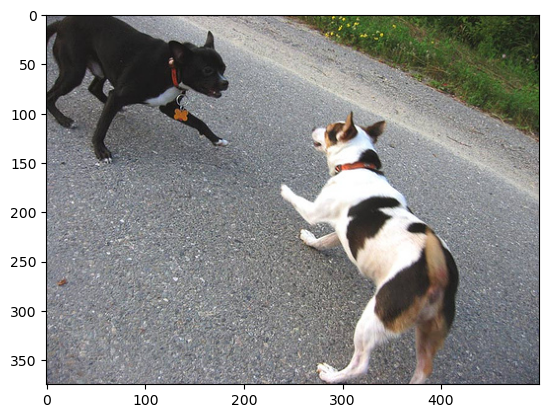

In [49]:
generate_caption("1001773457_577c3a7d70.jpg")

--------------Actual-----------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
-------------Predicted---------------
startseq little girl in pink dress is standing in front of painted painted building endseq


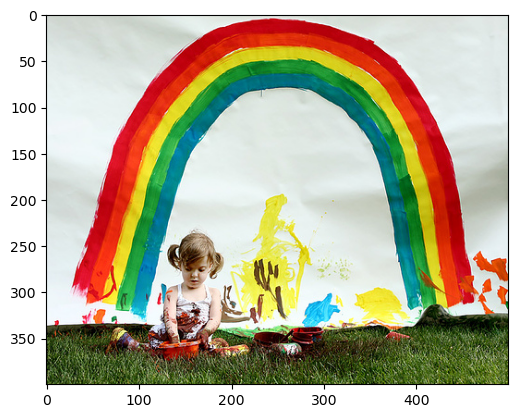

In [50]:
generate_caption("1002674143_1b742ab4b8.jpg")